# $\mathrm{NO_3}$

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "NO3" 
nice_name = "NO₃"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 794.221
min λ: 200.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

22123


4×7 DataFrame
 Row │ variable   mean           min          median       max         nmissin ⋯
     │ Symbol     Float64        Real         Float64      Real        Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          602.89         220.0        598.6        794.221             ⋯
   2 │ σ            2.14509e-18    5.146e-22    1.503e-18    2.28e-17
   3 │ T          294.767        294.0        294.0        300.0
   4 │ source_id   22.0123         2           20.0         45
                                                               2 columns omitted

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

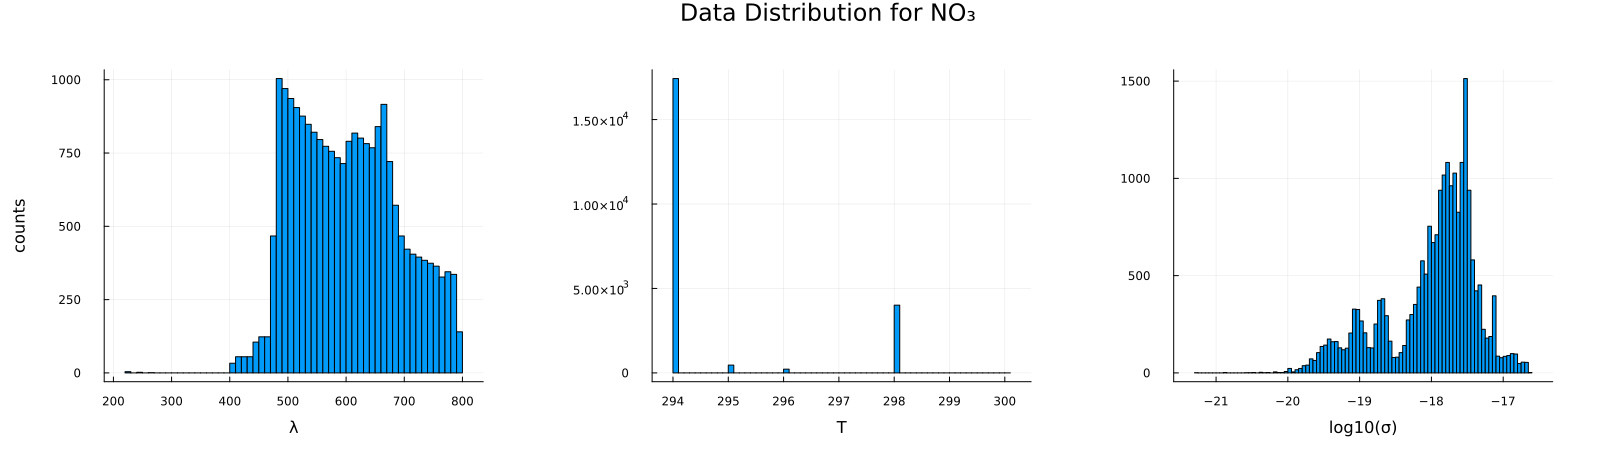

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

# Data Preprocessing

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

20259×3 DataFrame
   Row │ λ        σ            T       
       │ Float64  Float64      Float64 
───────┼───────────────────────────────
     1 │  654.01  1.25e-18       294.0
     2 │  655.78  1.24e-18       294.0
     3 │  657.8   2.0e-18        294.0
     4 │  658.76  3.39e-18       294.0
     5 │  659.8   6.2e-18        294.0
     6 │  660.81  1.03e-17       294.0
     7 │  661.82  1.2e-17        294.0
     8 │  662.78  1.17e-17       294.0
     9 │  663.81  1.03e-17       294.0
    10 │  664.85  8.08e-18       294.0
    11 │  665.81  7.38e-18       294.0
   ⋮   │    ⋮          ⋮          ⋮
 20250 │  692.0   7.93245e-20    298.0
 20251 │  692.2   7.88595e-20    298.0
 20252 │  692.4   7.84575e-20    298.0
 20253 │  692.6   8.07806e-20    298.0
 20254 │  692.8   8.2515e-20     298.0
 20255 │  693.2   8.78048e-20    298.0
 20256 │  693.4   8.60858e-20    298.0
 20257 │  693.6   8.8373e-20     298.0
 20258 │  693.8   8.644e-20      298.0
 20259 │  652.0   8.41e-19       300.0
                     20238 rows omitted

In [10]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

2018


3×7 DataFrame
 Row │ variable  mean           min          median        max           nmiss ⋯
     │ Symbol    Float64        Float64      Float64       Float64       Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         641.181        220.0        652.435       794.221             ⋯
   2 │ σ           2.53618e-18    5.146e-22    8.1085e-19    2.2103e-17
   3 │ T         294.554        294.0        294.0         298.0
                                                               2 columns omitted

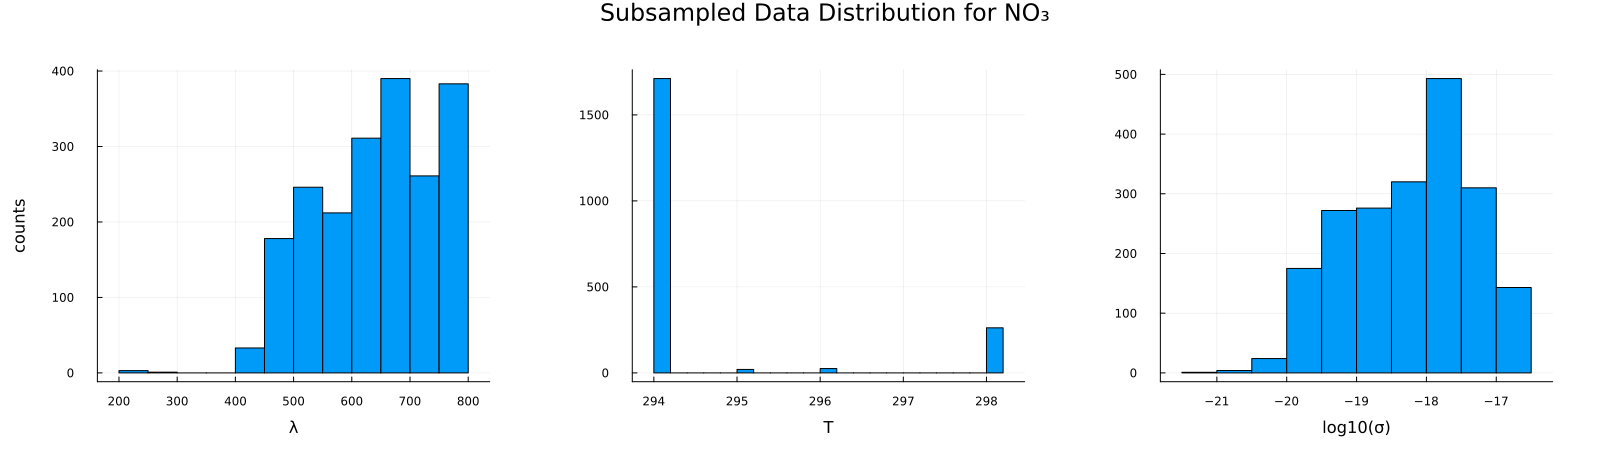

In [11]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

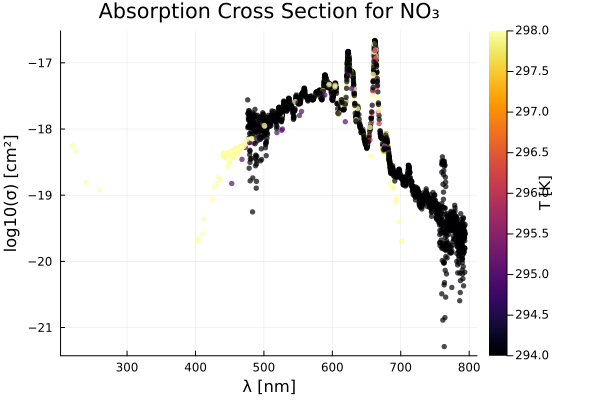

In [12]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [13]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1917


In [14]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

101-element Vector{Float64}:
 -19.412962882256544
 -18.30454809471646
 -16.76598918241282
 -18.031050319018657
 -17.475993554442628
 -16.95624487303132
 -17.211195506955352
 -18.384997385475412
 -18.592269271973663
 -17.1289527386945
 -18.536389170203133
 -17.66368839183176
 -16.921180816901153
   ⋮
 -19.01886121735934
 -17.695724949522873
 -17.147276089208795
 -18.920456992597092
 -17.742909680520977
 -16.734003629504922
 -19.619607839942972
 -17.394048842435126
 -19.07930286553008
 -18.69058277422186
 -18.772627557710365
 -17.79860287567955

In [15]:
# compute length scales
κ = 0.5
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [16]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.25381551993758433, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(5.299248445346651, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.9924465568978139, exp, 1.4901161193847656e-8)), 
  σ² = 0.031033397192800957, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [17]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     2.698847e+03     2.913968e+03
 * time: 0.01685309410095215
     1     1.139701e+03     4.440537e+02
 * time: 8.723037958145142
     2     9.085588e+02     1.904309e+02
 * time: 10.394252061843872
     3     8.058175e+02     3.175084e+02
 * time: 12.075232982635498
     4     6.911978e+02     4.391149e+02
 * time: 13.804086923599243
     5     5.504954e+02     6.935836e+02
 * time: 14.951180934906006
     6    -1.725746e+02     2.991622e+02
 * time: 16.649290084838867
     7    -2.403691e+02     6.382437e+01
 * time: 17.725493907928467
     8    -2.511126e+02     1.024340e+02
 * time: 18.886538982391357
     9    -2.617267e+02     1.205741e+02
 * time: 20.56327509880066
    10    -2.924185e+02     8.988971e+01
 * time: 22.237190008163452
    11    -3.130993e+02     8.444969e+01
 * time: 23.92255210876465
    12    -3.225305e+02     1.061426e+02
 * time: 25.029079914093018
    13    -3.353497e+02     3.697162e+01
 * time: 26.69891095161

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @316 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @587 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [18]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.06201564276064, 2.3780431464749348, 5.12628804213303, -3.4779056810810642],
 minimum = -344.9383587511503,
 iterations = 804,
 converged = false,)

In [19]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


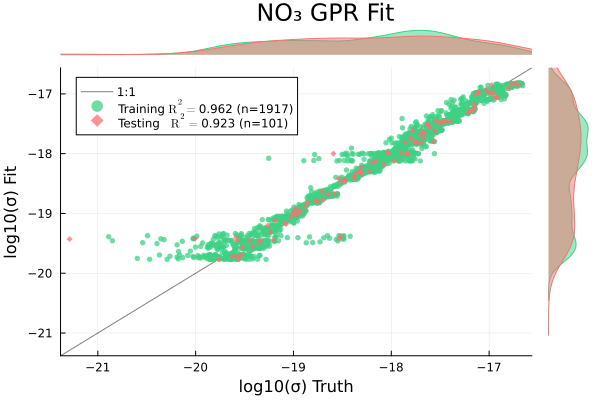

In [20]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

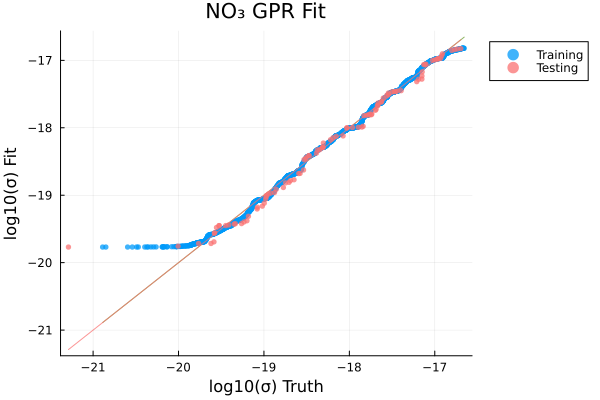

In [21]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


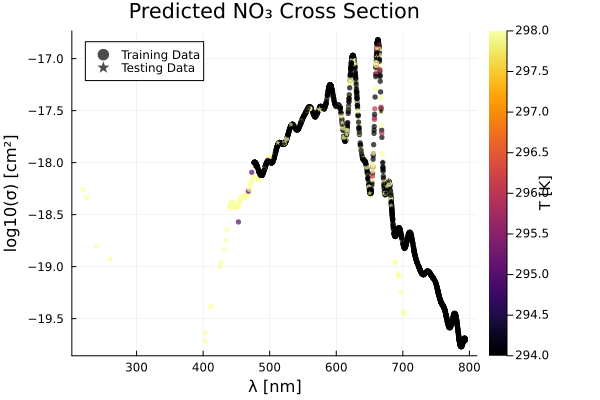

In [22]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

220.0
794.221


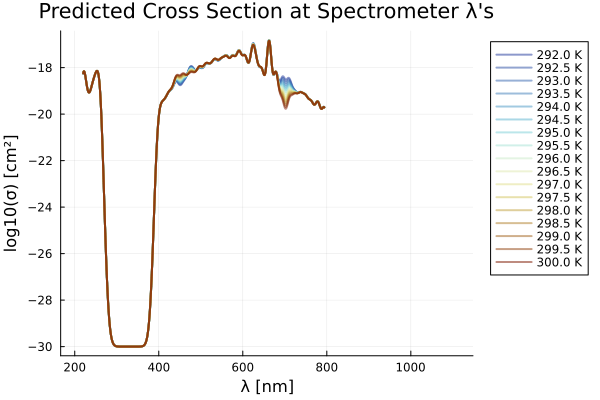

In [23]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

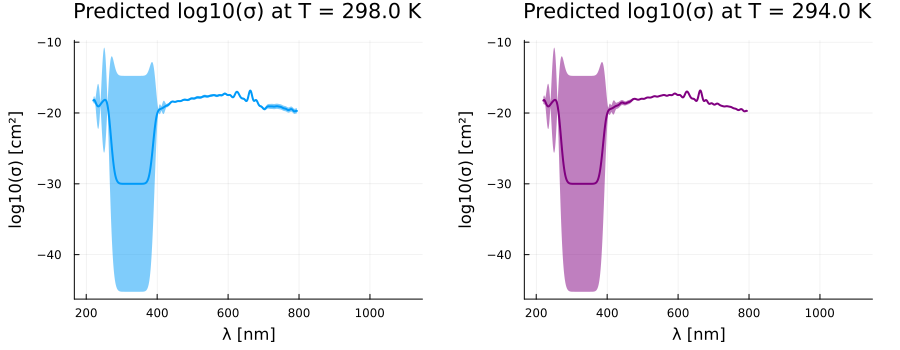

In [24]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [25]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

8×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.48434e-19    0.0      1.04592e-28     1.45924e-17
   7 │ σ_6         6.48434e-19    0.0      1.04592e-28     1.45924e-17
   8 │ σ_7         8.44881e-20    0.0      0.0             2.33958e-18
                                                               2 columns omitted

In [26]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

220.0	194.249
794.221	1120.216


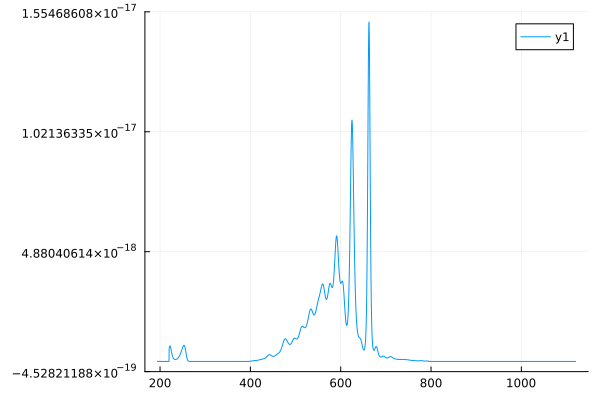

In [27]:
Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [28]:
df_photolysis_σ.σ_5 = σ
df_photolysis_σ.σ_6 = σ

describe(df_photolysis_σ)

8×7 DataFrame
 Row │ variable  mean           min      median         max             nmissi ⋯
     │ Symbol    Float64        Float64  Float64        Float64         Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         667.499        194.249  672.636        1120.22                ⋯
   2 │ σ_1         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   3 │ σ_2         5.26742e-19    0.0      2.82646e-22     1.17236e-17
   4 │ σ_3         2.15632e-20    0.0      0.0             7.82292e-19
   5 │ σ_4         1.25113e-19    0.0      6.4171e-21      6.41009e-19         ⋯
   6 │ σ_5         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   7 │ σ_6         6.58792e-19    0.0      1.71951e-28     1.5094e-17
   8 │ σ_7         8.44881e-20    0.0      0.0             2.33958e-18
                                                               2 columns omitted

In [29]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"